In [ ]:
%pip install numpy scikit-learn requests matplotlib.pyplot

Text(0, 0.5, 'Number of Occurrences by Postal code')

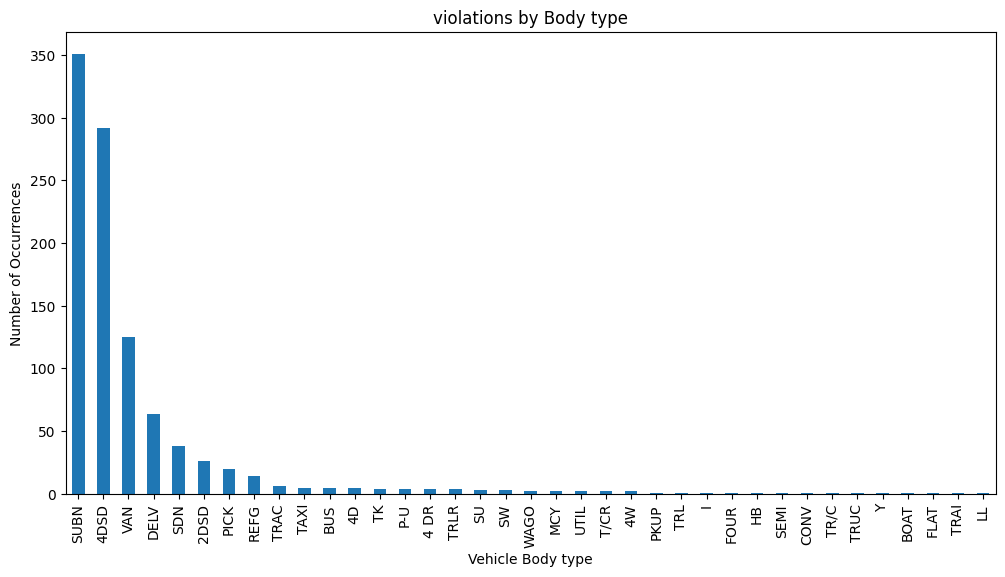

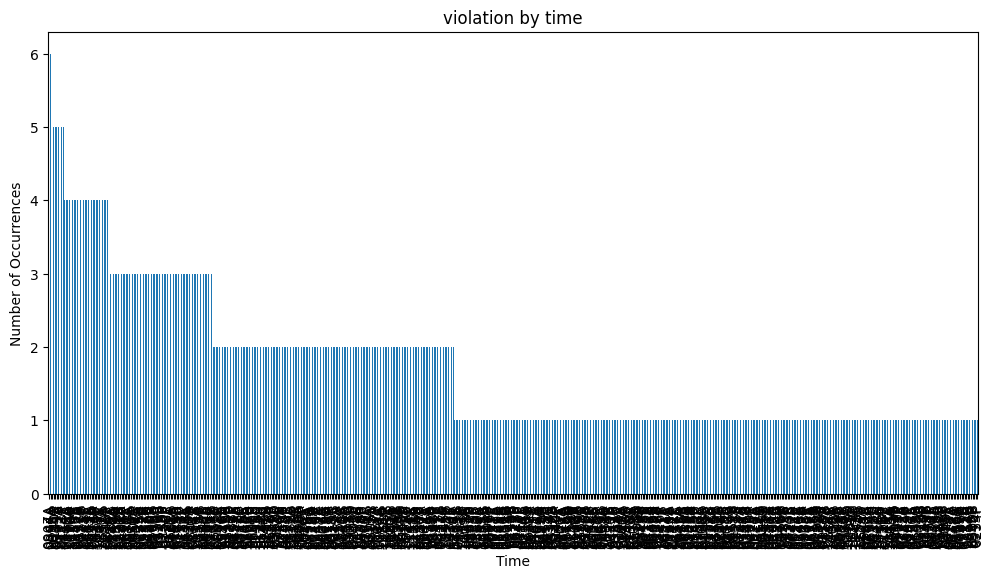

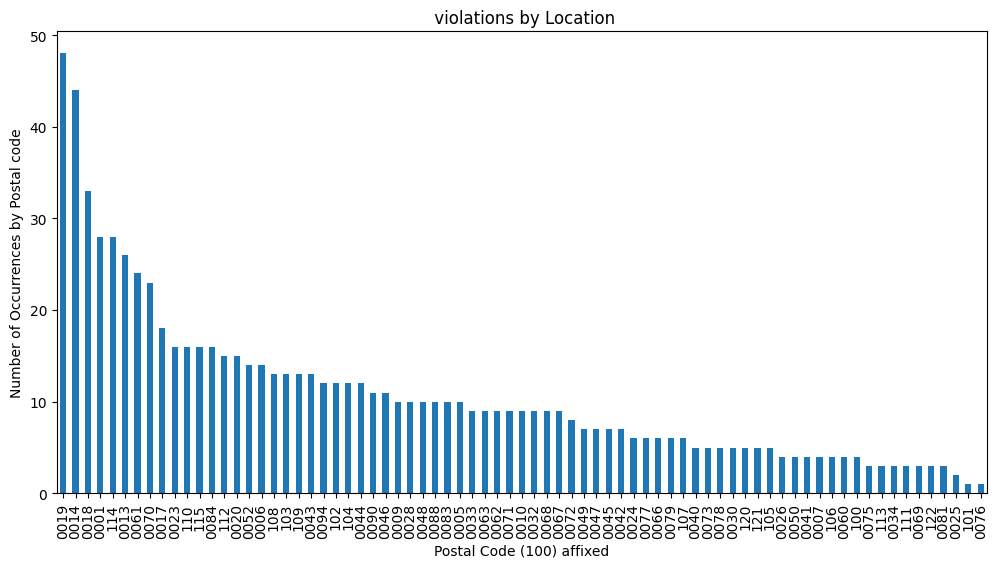

In [24]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
response= requests.get("https://data.cityofnewyork.us/resource/2bnn-yakx.json")
response_json= response.json()
df= pd.DataFrame(response_json)
#describe data 
# df['vehicle_body_type'].describe(include='all')
# df['from_hours_in_effect'].describe(include='all')
df.describe(include='all')
plt.figure(figsize=(12,6))
vehicle_counts=df['vehicle_body_type'].value_counts()
vehicle_counts.plot(kind='bar')
plt.title("violations by Body type")
plt.xlabel('Vehicle Body type')
plt.ylabel("Number of Occurrences")

plt.figure(figsize=(12,6))
vehicle_counts=df['violation_time'].value_counts()
vehicle_counts.plot(kind='bar')
plt.title("violation by time")
plt.xlabel('Time')
plt.ylabel("Number of Occurrences") #todo fix time displays its smooshed

plt.figure(figsize=(12,6))
vehicle_counts=df['violation_location'].value_counts()
vehicle_counts.plot(kind='bar')
plt.title(" violations by Location")
plt.xlabel('Postal Code (100) affixed')
plt.ylabel("Number of Occurrences by Postal code")
